# 基于PINN的N-S方程参数反演辨识
<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:0rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b>Copyright 2023 @ Authors</i></b><br/>
        作者：
            <b>
            <a href="zhhl_email@qq.com"> 张宏亮 📨 </a>
            </b>
        </i>
        <br/>
        日期：2023-08-28

<p style="color:purple; font-weight:bold">HIGHLIGHT:</p>
<p style="color:purple; font-weight:bold">将机器学习辅以日臻成熟且海量部署传感器用于流场重构预测和参数辨识</p>
<p style="color:purple; font-weight:bold">难点：对机器学习和物理过程同样熟悉
<p>区别于纯数据驱动及基于交互结合的硬约束条件，基于物理信息的神经网络（PINN）本质上是在全连接网络的基础上，加入软约束条件，即将含有物理信息的偏微分方程组成辅助函数作为残差项加入损失函数中，在通过误差反向传播算法进行最小化损失函数的同时逼近方程，以此达到融合物理信息的目的。</p>

<div>
    <img src="https://s2.loli.net/2023/08/29/Rbtm1QoMwpOdXlz.png" alt="Fig2" style="zoom: 60%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜机器学习+物理系统</p>
</div>




<div style="width:auto; height:2px; background:linear-gradient(244deg,rgba(0,0,0,0) 0%,rgba(0,0,0,0.5) 50%,rgba(0,0,0,1) 100%)"></div>

<div class="alert alert-success">
数学物理反问题是正问题的相对面，主要指根据已知的问题解反向推出问题条件或物理模型。在实际应用中，多数问题最终归结于各种已知的物理模型，而偏微分方程作为描述模型的主要方式，一直以来是科研人员研究的重点。
</div>

## 目录
* [背景介绍](#layer1)
* [ N-S方程中的参数识别](#layer2)
    * [模型描述](#2-1)
    * [构造辅助函数](#2-2)
    * [构造神经网络](#2-2)
* [代码实现](#layer3)
    * [导入相关库及其他文件](#3-1)
    * [构造NS辅助方程及计算域](#3-2)
    * [定义模型并进行训练](##3-3)
    * [参数反演结果](#3-4)
    * [流场重构预测](#3-5)
* [不足及展望](#layer4)    

# 1. 背景介绍<a id='layer1'></a>
许多工程领域及医学问题的解决常常伴随流场的预测和求解。如飞行器的外形结构设计、人体血管流动及疾病诊断、人居环境中温湿度的控制及污染物溯源。其本质是对一系列控制方程进行求解，除极个别可获得解析解的问题外，多采用计算物理模型对所研究区域内的物理场进行预测。

偏微分方程通常分为线性偏微分方程和非线性偏微分方程，前者包括热扩散方程、波动方程、拉普拉斯方程等，后者主要包括非线性扩散方程、冯卡门方程等，对上述方程中未知参数的求解即为偏微分方程的参数辨识。针对这类反问题，常用的求解方法有直接法、广义脉冲谱技术、线方法、概率统计法、优化法等。

<div>
    <img src="https://s2.loli.net/2023/08/29/AYBDO1JKglQUPNq.png" alt="Fig2" style="zoom: 45%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜参数辨识方法分类</p>
</div>

上述方法通常对真实解的精度要求严格，如最佳摄动法要求初始猜测值需在精确解的附近。此外，一些数据易受噪声影响且数值计算的计算量大精度低。因此如何在有限且含噪声的数据中进行更为精准的参数辨识成了研究重点之一。

## 2. N-S方程中的参数识别

### 2.1 模型描述<a id='2-1'></a>
描述不可压缩的二维Navier–Stokes方程可表示为：


$$\frac{{\partial u}}{{\partial t}} +u\frac{{\partial u}}{{\partial x}} + v\frac{{\partial u}}{{\partial y}} =  - \frac{1}{\rho }\frac{{\partial p}}{{\partial x}} + \nu (\frac{{{\partial ^2}u}}{{\partial {x^2}}} + \frac{{{\partial ^2}u}}{{\partial {y^2}}})$$

$$\frac{{\partial v}}{{\partial t}} +u\frac{{\partial v}}{{\partial x}} + v\frac{{\partial v}}{{\partial y}} =  - \frac{1}{\rho }\frac{{\partial p}}{{\partial y}} + \nu (\frac{{{\partial ^2}v}}{{\partial {x^2}}} + \frac{{{\partial ^2}v}}{{\partial {y^2}}})$$


$$\frac{{\partial u}}{{\partial x}} + \frac{{\partial u}}{{\partial y}} = 0$$

假设存在未知系数$C_1$和$C_1$于原方程中，可表述为
$$u _ { t } + c _ { 1 } ( u u_{ x } + v u _ { y } ) = - p _ { x } + c _ { 2 } ( u _ { x x } + u _ { y y } )$$
$$v _ { t } + c _ { 1 } ( u v_{ x } + v v _ { y } ) = - p _ { y } + c _ { 2 } ( v _ { x x } + v _ { y y } )$$
$$u _ { x } + v _ { y } =0$$

### 2.2 构造辅助函数<a id='2-2'></a>

根据二维不可压缩Navier-Stokes方程构造辅助函数为如下形式：

$$h_x = u _ { t } + c _ { 1 } ( u u_{ x } + v u _ { y } ) + p _ { x } - c _ { 2 } ( u _ { x x } + u _ { y y } )$$
$$h_y = v _ { t } + c _ { 1 } ( u v_{ x } + v v _ { y } ) + p _ { y } - c _ { 2 } ( v _ { x x } + v _ { y y } )$$
$$h_c = u _ { x } + v _ { y } $$

神经网络训练过程本质上是寻找损失函数最小值的过程，添加物理信息的方法是构造辅助函数并以平方差损失的形式加入损失项中，如果损失函数足够小就可以近似为零，如$hx$=$hy$=$hc$=0，即输出值满足各物理方程，以此达到增加训练物理可解释性的目的。

本文损失函数采用平方差损失函数，分为速度损失项，压力损失项及函数损失项，具体表达式如下：
$$\begin{array}{c}
loss\_total = loss + loss\_h\\
 = loss\_u + loss\_v + loss\_p + loss\_hx + loss\_hy + loss\_hc\\
 = \frac{1}{{2N}}\sum\limits_{i = 1}^N {({u_i} - {u_{pre - i}}} {)^2} + \frac{1}{{2N}}\sum\limits_{i = 1}^N {({v_i} - {v_{pre - i}}} {)^2} + \frac{1}{{2N}}\sum\limits_{i = 1}^N {({p_i} - {p_{pre - i}}} {)^2}
 + \frac{1}{{2N}}\sum\limits_{i = 1}^N {(h{x_i}} {)^2} + \frac{1}{{2N}}\sum\limits_{i = 1}^N {(h{y_i}} {)^2} + \frac{1}{{2N}}\sum\limits_{i = 1}^N {(h{c_i}} {)^2}
\end{array}$$

将所构造的辅助函数通过软约束的方式添加到神经网络损失函数中，如下图：

<div>
    <img src="https://s2.loli.net/2023/08/29/DoJ3EV8YTNnFGR9.png" alt="Fig2" style="zoom: 80%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜辅助方程软约束</p>
</div>

### 2.3 构造神经网络<a id='2-3'></a>
在确定了损失函数和数据集后，搭建合适的神经网络结构并选取符合算例的超参数决定了模型的精度与训练速度。首先，本文的网络共6层，其中输入层神经元数为3个，分别为空间坐标x,y和时间t，输出层神经元共3个，分别为速度的x方向分量$u$，$y$方向分量$v$，压力$p$，剩余6层为隐藏层，每层神经元数量为50个。其次，激活函数选取$tanh$，初始化方法为$Glorot uniform$。经过对比，改变学习率从0.001为0.0001进行两次训练。

根据以上各参数的选取，本文网络的结构如下图


<div>
    <img src="https://s2.loli.net/2023/08/29/BAjhKtwSxIL39uT.png" alt="Fig2" style="zoom: 65%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜神经网络结构</p>
</div>

## 3 代码实现<a id='layer3'></a>
<div style="padding: 10px; background-color: #f5f5f5; color: black; margin-bottom: 15px; border-radius: 30px;">
    <p style='padding: 10px'>代码依赖DeepXDE库完成，DeepXDE 是一个用于科学机器学习和物理信息学习的库</b></p>
    <div>
    <img src="https://s2.loli.net/2023/08/29/ri95dMkBxR8QGLS.png" alt="Fig2" style="zoom: 80%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜现所支持框架</p>

<div style="width:auto; height:2px; background:linear-gradient(244deg,rgba(0,0,0,0) 0%,rgba(0,0,0,0.5) 50%,rgba(0,0,0,1) 100%)"></div>

### 3.1 导入相关库及其他文件<a id='3-1'></a>

In [1]:
!pip install deepxde --upgrade --quiet
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


设定需反演辨识参数的真实值

In [2]:
C1true = 1.0
C2true = 0.01

导入训练数据，包含四个变量，分别是速度（$U$, $V$)、压力（$P$）、时间（$t$）、和坐标（$X$）

In [3]:
def load_training_data(num):
    data = loadmat("cylinder_nektar_wake.mat")
    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]       # T x 1
    X_star = data["X_star"]  # N x 2
    N = X_star.shape[0]      # 5000
    T = t_star.shape[0]      # 200
    
    # 数组变形及摊平操作
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T
    UU = U_star[:, 0, :]            # N x T
    VV = U_star[:, 1, :]            # N x T
    PP = P_star  # N x T
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    
    # 时空域筛选: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    data2 = data1[:, :][data1[:, 2] <= 7]
    data3 = data2[:, :][data2[:, 0] >= 1]
    data4 = data3[:, :][data3[:, 0] <= 8]
    data5 = data4[:, :][data4[:, 1] >= -2]
    data_domain = data5[:, :][data5[:, 1] <= 2]
    
    # 随机选择训练数据
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    
    return [x_train, y_train, t_train, u_train, v_train, p_train]

利用dde内置变量类型，定义两个需反演的变量

In [4]:
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

### 3.2 构造NS辅助方程及计算域<a id='3-2'></a>

In [5]:
# x为空间坐标，y为个各变量
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    # 计算各变量在时空域的导数
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    # 描述连续性方程
    continuity = du_x + dv_y
    # 描述动量方程
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

In [ ]:
定义时空计算域

In [6]:
# 矩形空间计算域
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0

# 利用dde内置函数geometry.Rectangle定义: X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# # 利用dde内置函数geometry.TimeDomain定义 T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)

# 组合
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

获得训练数据num = 7000，利用点形式约束边界（非常规三类边界条件）

In [7]:
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

### 3.3 定义模型并进行训练<a id='3-3'></a>

Compiling model...
'compile' took 0.000218 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.51e-03, 4.23e-03, 1.78e-02, 6.47e-01, 1.21e-01]    [3.51e-03, 4.23e-03, 1.78e-02, 6.47e-01, 1.21e-01]    []  
1000      [7.83e-04, 1.98e-03, 1.34e-03, 4.17e-03, 6.35e-03]    [7.83e-04, 1.98e-03, 1.34e-03, 4.17e-03, 6.35e-03]    []  
2000      [4.02e-04, 5.76e-04, 5.82e-04, 1.56e-03, 1.95e-03]    [4.02e-04, 5.76e-04, 5.82e-04, 1.56e-03, 1.95e-03]    []  
3000      [2.51e-04, 4.57e-04, 3.68e-04, 1.06e-03, 1.28e-03]    [2.51e-04, 4.57e-04, 3.68e-04, 1.06e-03, 1.28e-03]    []  
4000      [2.07e-04, 3.64e-04, 2.55e-04, 7.55e-04, 8.80e-04]    [2.07e-04, 3.64e-04, 2.55e-04, 7.55e-04, 8.80e-04]    []  
5000      [1.75e-04, 2.86e-04, 1.95e-04, 5.85e-04, 6.64e-04]    [1.75e-04, 2.86e-04, 1.95e-04, 5.85e-04, 6.64e-04]    []  
6000      [1.40e-04, 2.35e-04, 1.63e-04, 4.29e-04, 5.39e-04]    [1.

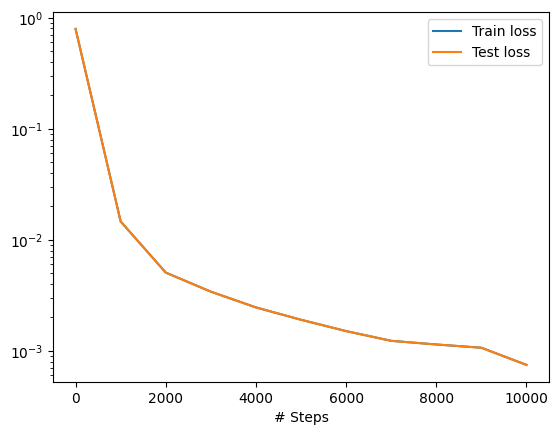

In [8]:
# 利用data.TimePDE函数描述物理模型
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

# 定义神经网相关参数和模型
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

# 创建DeepXDE回调来存储模型训练过程中两个变量C1和C2的值
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)

# 编译训练，C1, C2为需训练变量
model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

利用更小的学习率再次编译训练

Compiling model...
'compile' took 0.001281 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
10000     [7.15e-05, 1.27e-04, 1.02e-04, 1.94e-04, 2.53e-04]    [7.15e-05, 1.27e-04, 1.02e-04, 1.94e-04, 2.53e-04]    []  
11000     [6.44e-05, 1.15e-04, 9.37e-05, 1.66e-04, 2.15e-04]    [6.44e-05, 1.15e-04, 9.37e-05, 1.66e-04, 2.15e-04]    []  
12000     [5.74e-05, 1.03e-04, 8.42e-05, 1.42e-04, 1.75e-04]    [5.74e-05, 1.03e-04, 8.42e-05, 1.42e-04, 1.75e-04]    []  
13000     [5.20e-05, 9.32e-05, 7.62e-05, 1.22e-04, 1.43e-04]    [5.20e-05, 9.32e-05, 7.62e-05, 1.22e-04, 1.43e-04]    []  
14000     [4.79e-05, 8.44e-05, 6.94e-05, 1.07e-04, 1.22e-04]    [4.79e-05, 8.44e-05, 6.94e-05, 1.07e-04, 1.22e-04]    []  
15000     [4.43e-05, 7.71e-05, 6.43e-05, 9.46e-05, 1.08e-04]    [4.43e-05, 7.71e-05, 6.43e-05, 9.46e-05, 1.08e-04]    []  
16000     [4.38e-05, 7.14e-05, 6.06e-05, 8.54e-05, 9.92e-05]    [4.

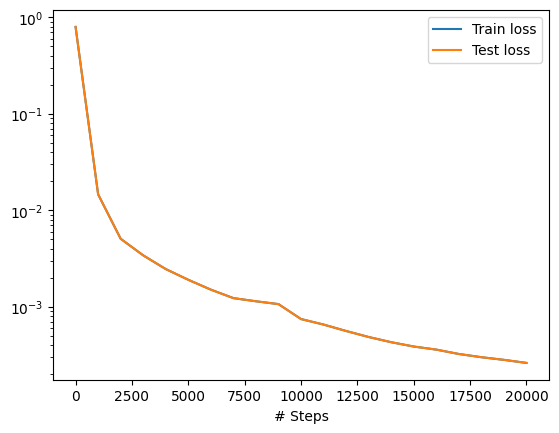

In [9]:
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(epochs=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

### 3.4 参数反演结果<a id='3-4'></a>

In [10]:
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

Mean residual: 0.0045395796


参数辨识结果，绘制$C_1$和$C_2$的结果

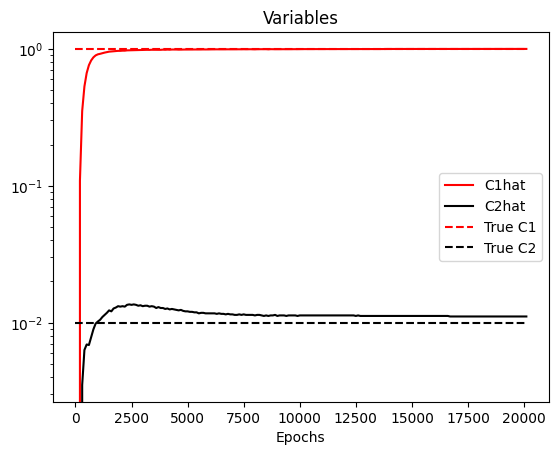

In [11]:
lines = open(fnamevar, "r").readlines()
Chat = np.array( [np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len), sep=",",) for line in lines])
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

### 3.5 流场重构预测<a id='3-5'></a>

显示训练得到的7s内速度场分布情况

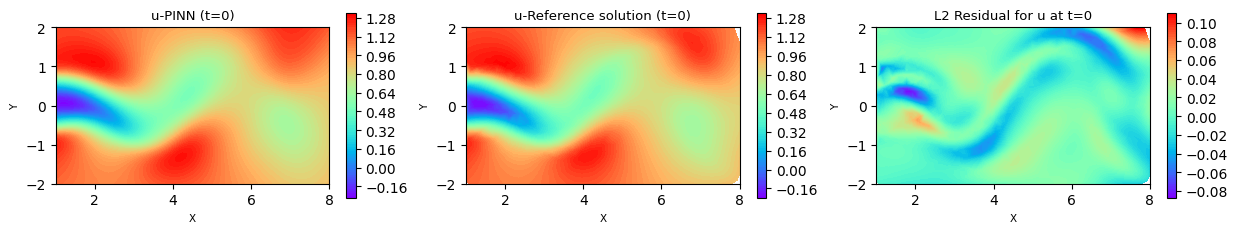

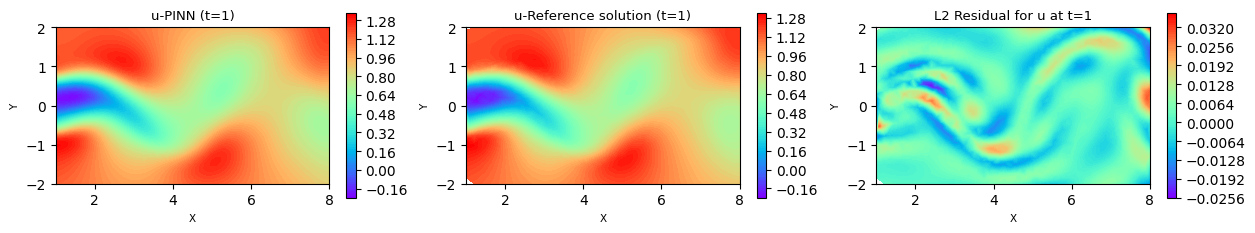

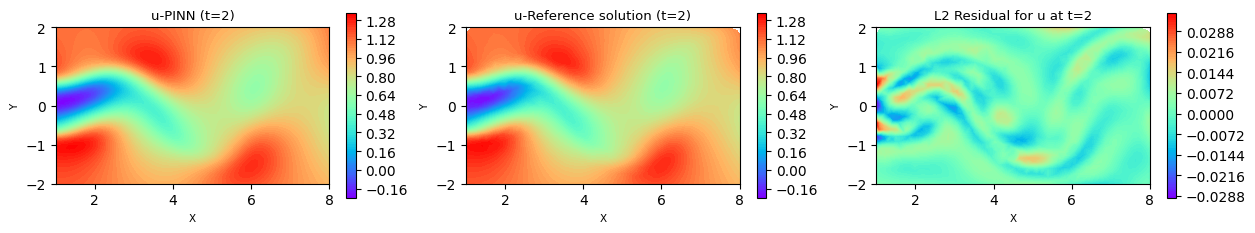

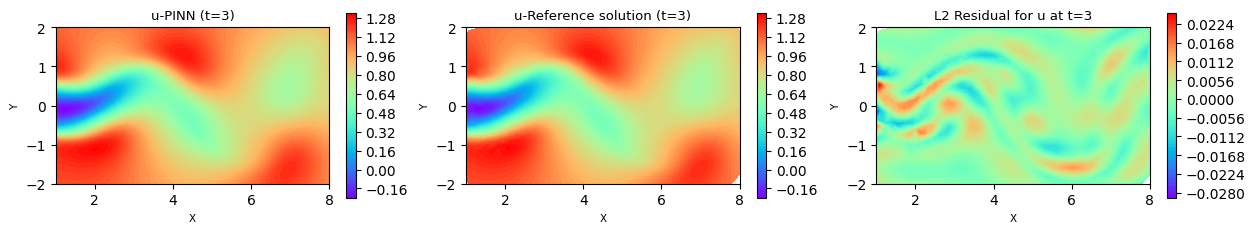

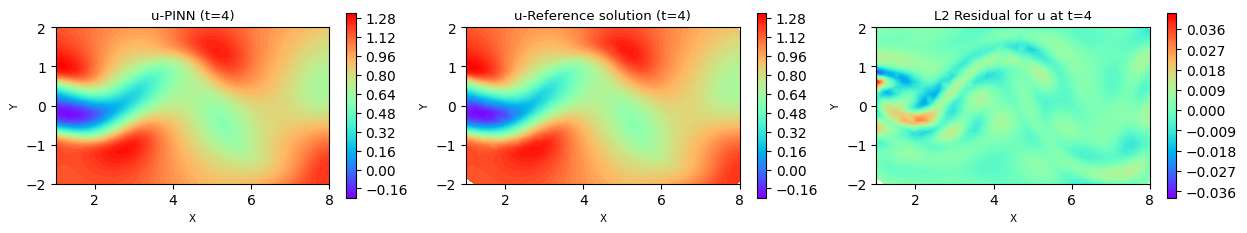

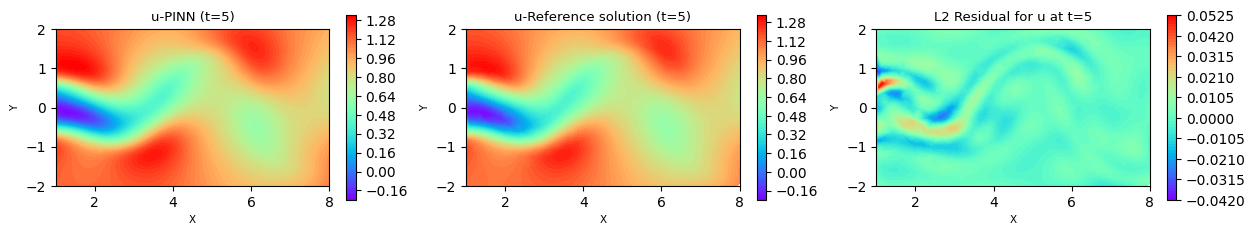

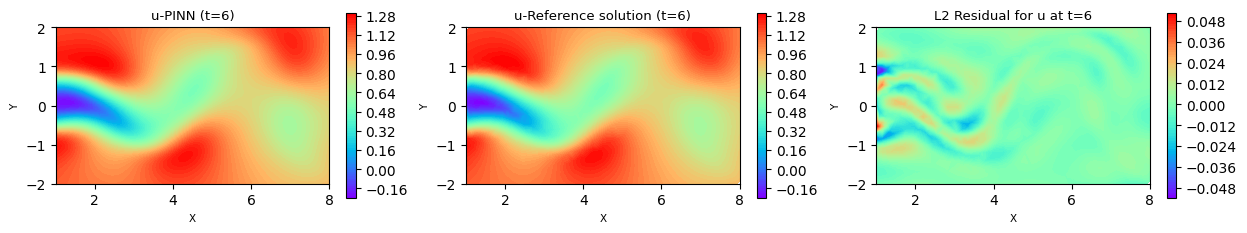

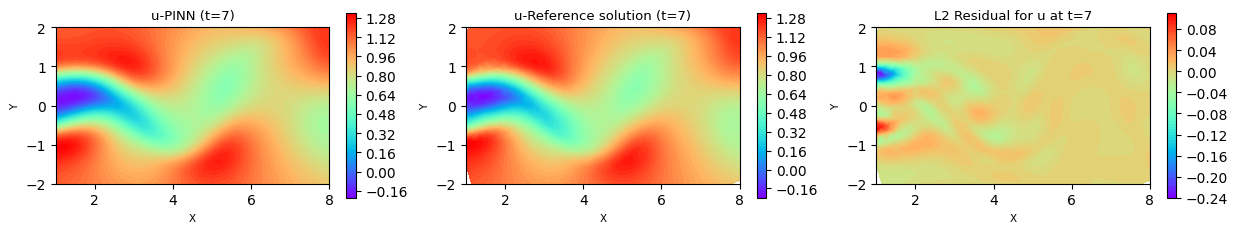

In [49]:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 12))
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    pos0 = ax[0].get_position()
    cb0 = plt.colorbar(cntr0, ax=ax[0], aspect=20, shrink=0.2)
    
    cntr1 = ax[1].tricontourf(x_true, y_true, u_true, levels=80, cmap="rainbow")
    pos1 = ax[1].get_position()
    cb1 = plt.colorbar(cntr1, ax=ax[1], aspect=20, shrink=0.2)
    
    # Filter data by time t
    indices_t = np.where(ob_t == t)
    x_t = ob_x[indices_t].flatten()
    y_t = ob_y[indices_t].flatten()
    u_true = ob_u[indices_t]
    xyt_pred = np.hstack((x_t.reshape(-1, 1), y_t.reshape(-1, 1), t * np.ones((len(x_t), 1))))
    uvp_pred = model.predict(xyt_pred)
    u_pred = uvp_pred[:, 0]
    residual = u_pred - u_true
    
    cntr2 = ax[2].tricontourf(x_t, y_t, residual, levels=80, cmap="rainbow")
    pos2 = ax[2].get_position()
    cb2 = plt.colorbar(cntr2, ax=ax[2], aspect=20, shrink=0.2)
       
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5)
    ax[0].set_ylabel("Y", fontsize=7.5)
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5)
    ax[1].set_ylabel("Y", fontsize=7.5)
    ax[2].set_title("L2 Residual for u at t=" + str(t), fontsize=9.5)
    ax[2].axis("scaled")
    ax[2].set_xlabel("X", fontsize=7.5)
    ax[2].set_ylabel("Y", fontsize=7.5)
    plt.show()

## 不足及展望<a id='layer4'></a>

1. 开发自己的PINN库，并部署到类似的开放式平台
2. 针对不同的应用场景，统一框架和范式，降低使用门槛
3. 关于硬约束条件的进一步研究